# Method Comparison - Haber et. al dataset

# Figure 5 Reproducibility Notebook

In [1]:
import os
os.chdir("../")

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import os
import reptrvae

Using TensorFlow backend.


In [3]:
sc.set_figure_params(dpi=200)

In [4]:
path_to_save = "./results/haber/"
sc.settings.figdir = path_to_save

In [5]:
specific_cell_type = "Tuft"

In [6]:
cell_type_key = "cell_label"
condition_key = "condition"
target_condition = "Hpoly.Day10"
conditions = ['Control', 'Hpoly.Day10']

In [7]:
adata = sc.read("./data/haber/haber_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


saving figure to file ../trVAE_reproducibility/results/Figure 2/umap_haber_original.pdf


/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


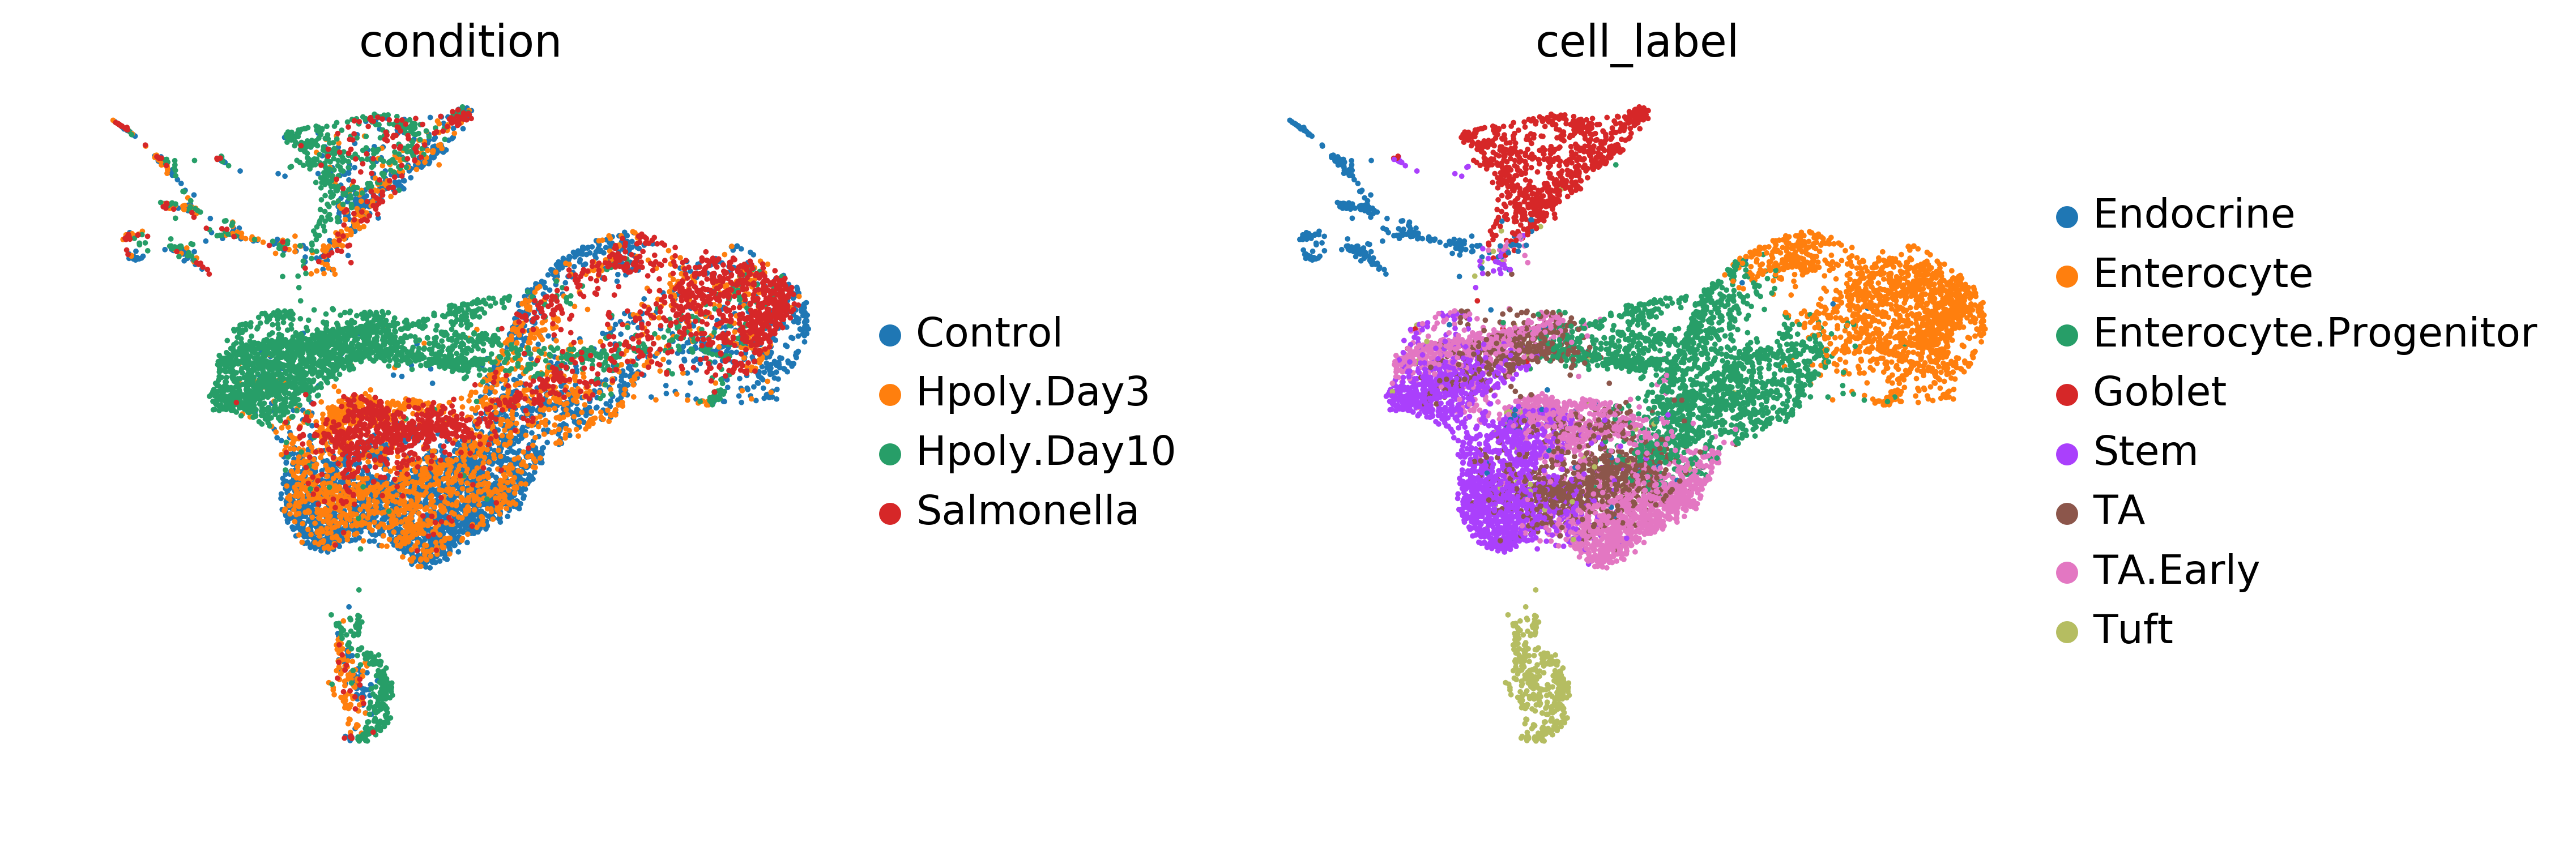

In [20]:
sc.pl.umap(adata, 
           color=[condition_key, cell_type_key], 
           wspace=0.4, 
           save='_haber_original.pdf',
           frameon=False)

In [8]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [9]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
cell_type_adata

View of AnnData object with n_obs × n_vars = 277 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [10]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == 'Control']
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [11]:
ctrl_adata.obs['method'] = 'Control'
real_adata.obs['method'] = target_condition

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [12]:
trvae_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/trVAE.h5ad")
trvae_reconstructed

AnnData object with n_obs × n_vars = 258 × 1000 
    obs: 'barcode', 'batch', 'cell_label', 'condition', 'n_counts'

In [13]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"Control_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

In [14]:
scvi_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/scVI-Tuft.h5ad")
scgen_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/scGen-Tuft.h5ad")
saucie_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/SAUCIE-Tuft.h5ad")
cgan_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/cgan_Tuft.h5ad")
cvae_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/CVAE-Tuft.h5ad")
mmdcvae_reconstructed = sc.read("../trVAE_reproducibility/data/reconstructed/haber/MMDCVAE-Tuft.h5ad")

In [15]:
scvi_pred = scvi_reconstructed[scvi_reconstructed.obs[condition_key] == f"{specific_cell_type}_pred_{target_condition}"]
scvi_pred.var = ctrl_adata.var
scvi_pred.obs['method'] = 'scVI'

In [16]:
scgen_pred = scgen_reconstructed[scgen_reconstructed.obs[condition_key] == f"{specific_cell_type}_pred_{target_condition}"]
scgen_pred.var = ctrl_adata.var
scgen_pred.obs['method'] = 'scGen'

In [17]:
saucie_pred = saucie_reconstructed[saucie_reconstructed.obs[condition_key] == f"{specific_cell_type}_pred_{target_condition}"]
saucie_pred.var_names = ctrl_adata.var_names
saucie_pred.obs['method'] = 'SAUCIE'

Trying to set attribute `.obs` of view, making a copy.


In [18]:
cgan_pred = cgan_reconstructed[cgan_reconstructed.obs[condition_key] == f"pred_{target_condition}"]
cgan_pred.var = ctrl_adata.var
cgan_pred.obs['method'] = 'Cycle GAN'

In [19]:
cvae_pred = cvae_reconstructed[cvae_reconstructed.obs[condition_key] == f"{specific_cell_type}_pred_{target_condition}"]
cvae_pred.var = ctrl_adata.var
cvae_pred.obs['method'] = 'CVAE'

In [20]:
mmdcvae_pred = mmdcvae_reconstructed[mmdcvae_reconstructed.obs[condition_key] == f"Control_to_{target_condition}"]
mmdcvae_pred.var = ctrl_adata.var
mmdcvae_pred.obs['method'] = 'MMD-CVAE'

In [21]:
models = ctrl_adata.concatenate(real_adata, trvae_pred, scgen_pred, mmdcvae_pred, scvi_pred, cvae_pred, saucie_pred, cgan_pred)
models.obs['method'].unique()

array(['Control', 'Hpoly.Day10', 'trVAE', 'scGen', 'MMD-CVAE', 'scVI',
       'CVAE', 'SAUCIE', 'Cycle GAN'], dtype=object)

... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical
... storing 'method' as categorical


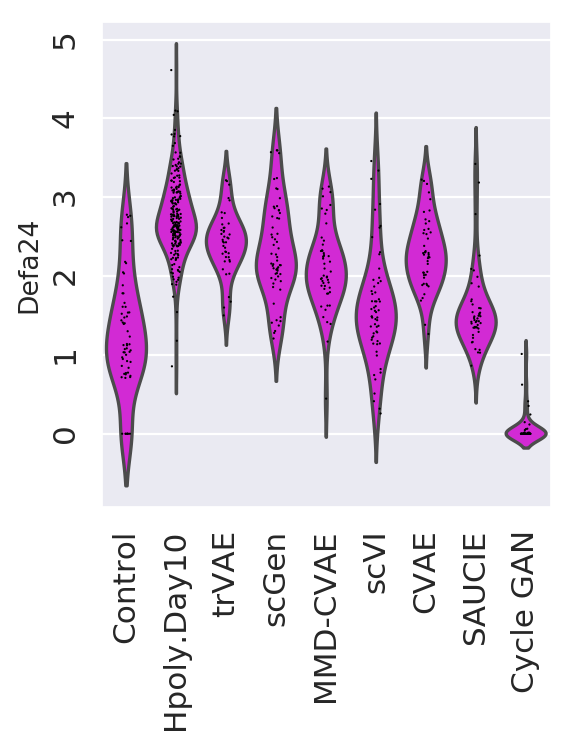

In [22]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="Defa24", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_model_cmpr.pdf",
             jitter=True,
            )
os.rename(src=os.path.join(path_to_save, "violin_model_cmpr.pdf"), 
          dst=os.path.join(path_to_save, "violin_model_comparison.pdf"))

In [23]:
def calc_R2_specific_model_mean(pred_adata, cell_type_adata, n_genes, conditions):
    real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]
    if n_genes != pred_adata.shape[1]:
        if not cell_type_adata.uns.keys().__contains__("rank_gene_groups"):
            sc.tl.rank_genes_groups(cell_type_adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = cell_type_adata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        pred_adata = pred_adata[:, diff_genes.tolist()]
        real_adata = real_adata[:, diff_genes.tolist()]
    r2_means, r2_means_std = [], []
    r2_vars, r2_vars_std = [], []
    r_values_mean = np.zeros((1, 1000))
    r_values_var = np.zeros((1, 1000))
    for i in range(1000):
        pred_adata_idx = np.random.choice(range(0, pred_adata.shape[0]), int(1.0 * pred_adata.shape[0]))
        real_adata_idx = np.random.choice(range(0, real_adata.shape[0]), int(1.0 * real_adata.shape[0]))
        if sparse.issparse(pred_adata.X):
            pred_adata.X = pred_adata.X.A
            real_adata.X = real_adata.X.A
        x_mean = np.mean(pred_adata.X[pred_adata_idx], axis=0)
        y_mean = np.mean(real_adata.X[real_adata_idx], axis=0)
        
        x_var = np.var(pred_adata.X[pred_adata_idx], axis=0)
        y_var = np.var(real_adata.X[real_adata_idx], axis=0)
        
        m, b, r_value_mean, p_value, std_err_mean = stats.linregress(x_mean, y_mean)
        m, b, r_value_var, p_value, std_err_var = stats.linregress(x_var, y_var)
        
        r_values_mean[0, i] = r_value_mean ** 2
        r_values_var[0, i] = r_value_var ** 2

#     print(r_values_mean.mean(), r_values_mean.std(), r_values_var.mean(), r_values_var.std())
    return r_values_mean.mean(), r_values_mean.std(), r_values_var.mean(), r_values_var.std()

In [24]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)


In [30]:
def grouped_barplot(df, models, types, r2s, r2_stds, filename, put_label=False, legend=False, offset=0.375, step=2):
    plt.close("all")
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=35)
    unique_models = df[models].unique()
    x_pos = np.arange(0, step * len(unique_models), step)
    unique_types = df[types].unique()
    plt.figure(figsize=(12, 10))
    for i, group in enumerate(unique_types):
        group_df = df[df[types] == group]
        b = plt.bar(x_pos + i / 1.25, group_df[r2s].values, capsize=10, alpha=0.95, label=f"{group}",
                    yerr=group_df[r2_stds].values)
        a = np.random.normal(group_df[r2s].values, group_df[r2_stds].values, (10, len(unique_models)))
        plt.plot(x_pos + i / 1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)

    plt.ylabel(r"$\mathrm{R^2}$", fontsize=30)
    plt.xticks(x_pos + offset, unique_models, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, filename), dpi=300)
    plt.show()


In [26]:
conditions = {"real_stim": f"{target_condition}", "pred_stim": f"{specific_cell_type}_pred_{target_condition}"}
trvae_r2_mean, trvae_r2_mean_std, trvae_r2_var, trvae_r2_var_std = calc_R2_specific_model_mean(trvae_pred, cell_type_adata, n_genes=1000, conditions=conditions)
mmdcvae_r2_mean, mmdcvae_r2_mean_std, mmdcvae_r2_var, mmdcvae_r2_var_std = calc_R2_specific_model_mean(mmdcvae_pred, cell_type_adata, n_genes=1000, conditions=conditions)
scvi_r2_mean, scvi_r2_mean_std, scvi_r2_var, scvi_r2_var_std = calc_R2_specific_model_mean(scvi_pred, cell_type_adata, n_genes=1000, conditions=conditions)
saucie_r2_mean, saucie_r2_mean_std, saucie_r2_var, saucie_r2_var_std = calc_R2_specific_model_mean(saucie_pred, cell_type_adata, n_genes=1000, conditions=conditions)
scgen_r2_mean, scgen_r2_mean_std, scgen_r2_var, scgen_r2_var_std = calc_R2_specific_model_mean(scgen_pred, cell_type_adata, n_genes=1000, conditions=conditions)
cvae_r2_mean, cvae_r2_mean_std, cvae_r2_var, cvae_r2_var_std = calc_R2_specific_model_mean(cvae_pred, cell_type_adata, n_genes=1000, conditions=conditions)
cgan_r2_mean, cgan_r2_mean_std, cgan_r2_var, cgan_r2_var_std = calc_R2_specific_model_mean(cgan_pred, cell_type_adata, n_genes=1000, conditions=conditions)

In [28]:
all_means = np.array([trvae_r2_mean, scgen_r2_mean, mmdcvae_r2_mean, scvi_r2_mean,cvae_r2_mean, saucie_r2_mean, cgan_r2_mean])
all_means_std = np.array([trvae_r2_mean_std, scgen_r2_mean_std, mmdcvae_r2_mean_std, scvi_r2_mean_std, cvae_r2_mean_std, saucie_r2_mean_std, cgan_r2_mean_std])
all_vars = np.array([trvae_r2_var, scgen_r2_var, mmdcvae_r2_var, scvi_r2_var, cvae_r2_var, saucie_r2_var, cgan_r2_var])
all_vars_std = np.array([trvae_r2_var_std, scgen_r2_var_std, mmdcvae_r2_var_std, scvi_r2_var_std, cvae_r2_var_std, saucie_r2_var_std, cgan_r2_var_std])
all_types = ["Mean"] * 7 + ["Variance"] * 7
models = ["trVAE", "scGen", "MMD-CVAE", "scVI", "CVAE", "SAUCIE", "Cycle GAN",] * 2
df = pd.DataFrame({"R^2": np.concatenate([all_means, all_vars]), "R^2 Stddevs": np.concatenate([all_means_std, all_vars_std]), "Type": all_types, "Models": models})
df

,R^2,R^2 Stddevs,Type,Models
0,0.967910,0.006756,Mean,trVAE
1,0.890793,0.006201,Mean,scGen
2,0.813777,0.005195,Mean,MMD-CVAE
3,0.895190,0.010451,Mean,scVI
4,0.742013,0.006522,Mean,CVAE
5,0.873630,0.004302,Mean,SAUCIE
6,0.037774,0.003778,Mean,Cycle GAN
7,0.867269,0.040727,Variance,trVAE
8,0.747049,0.036358,Variance,scGen
9,0.636891,0.029260,Variance,MMD-CVAE


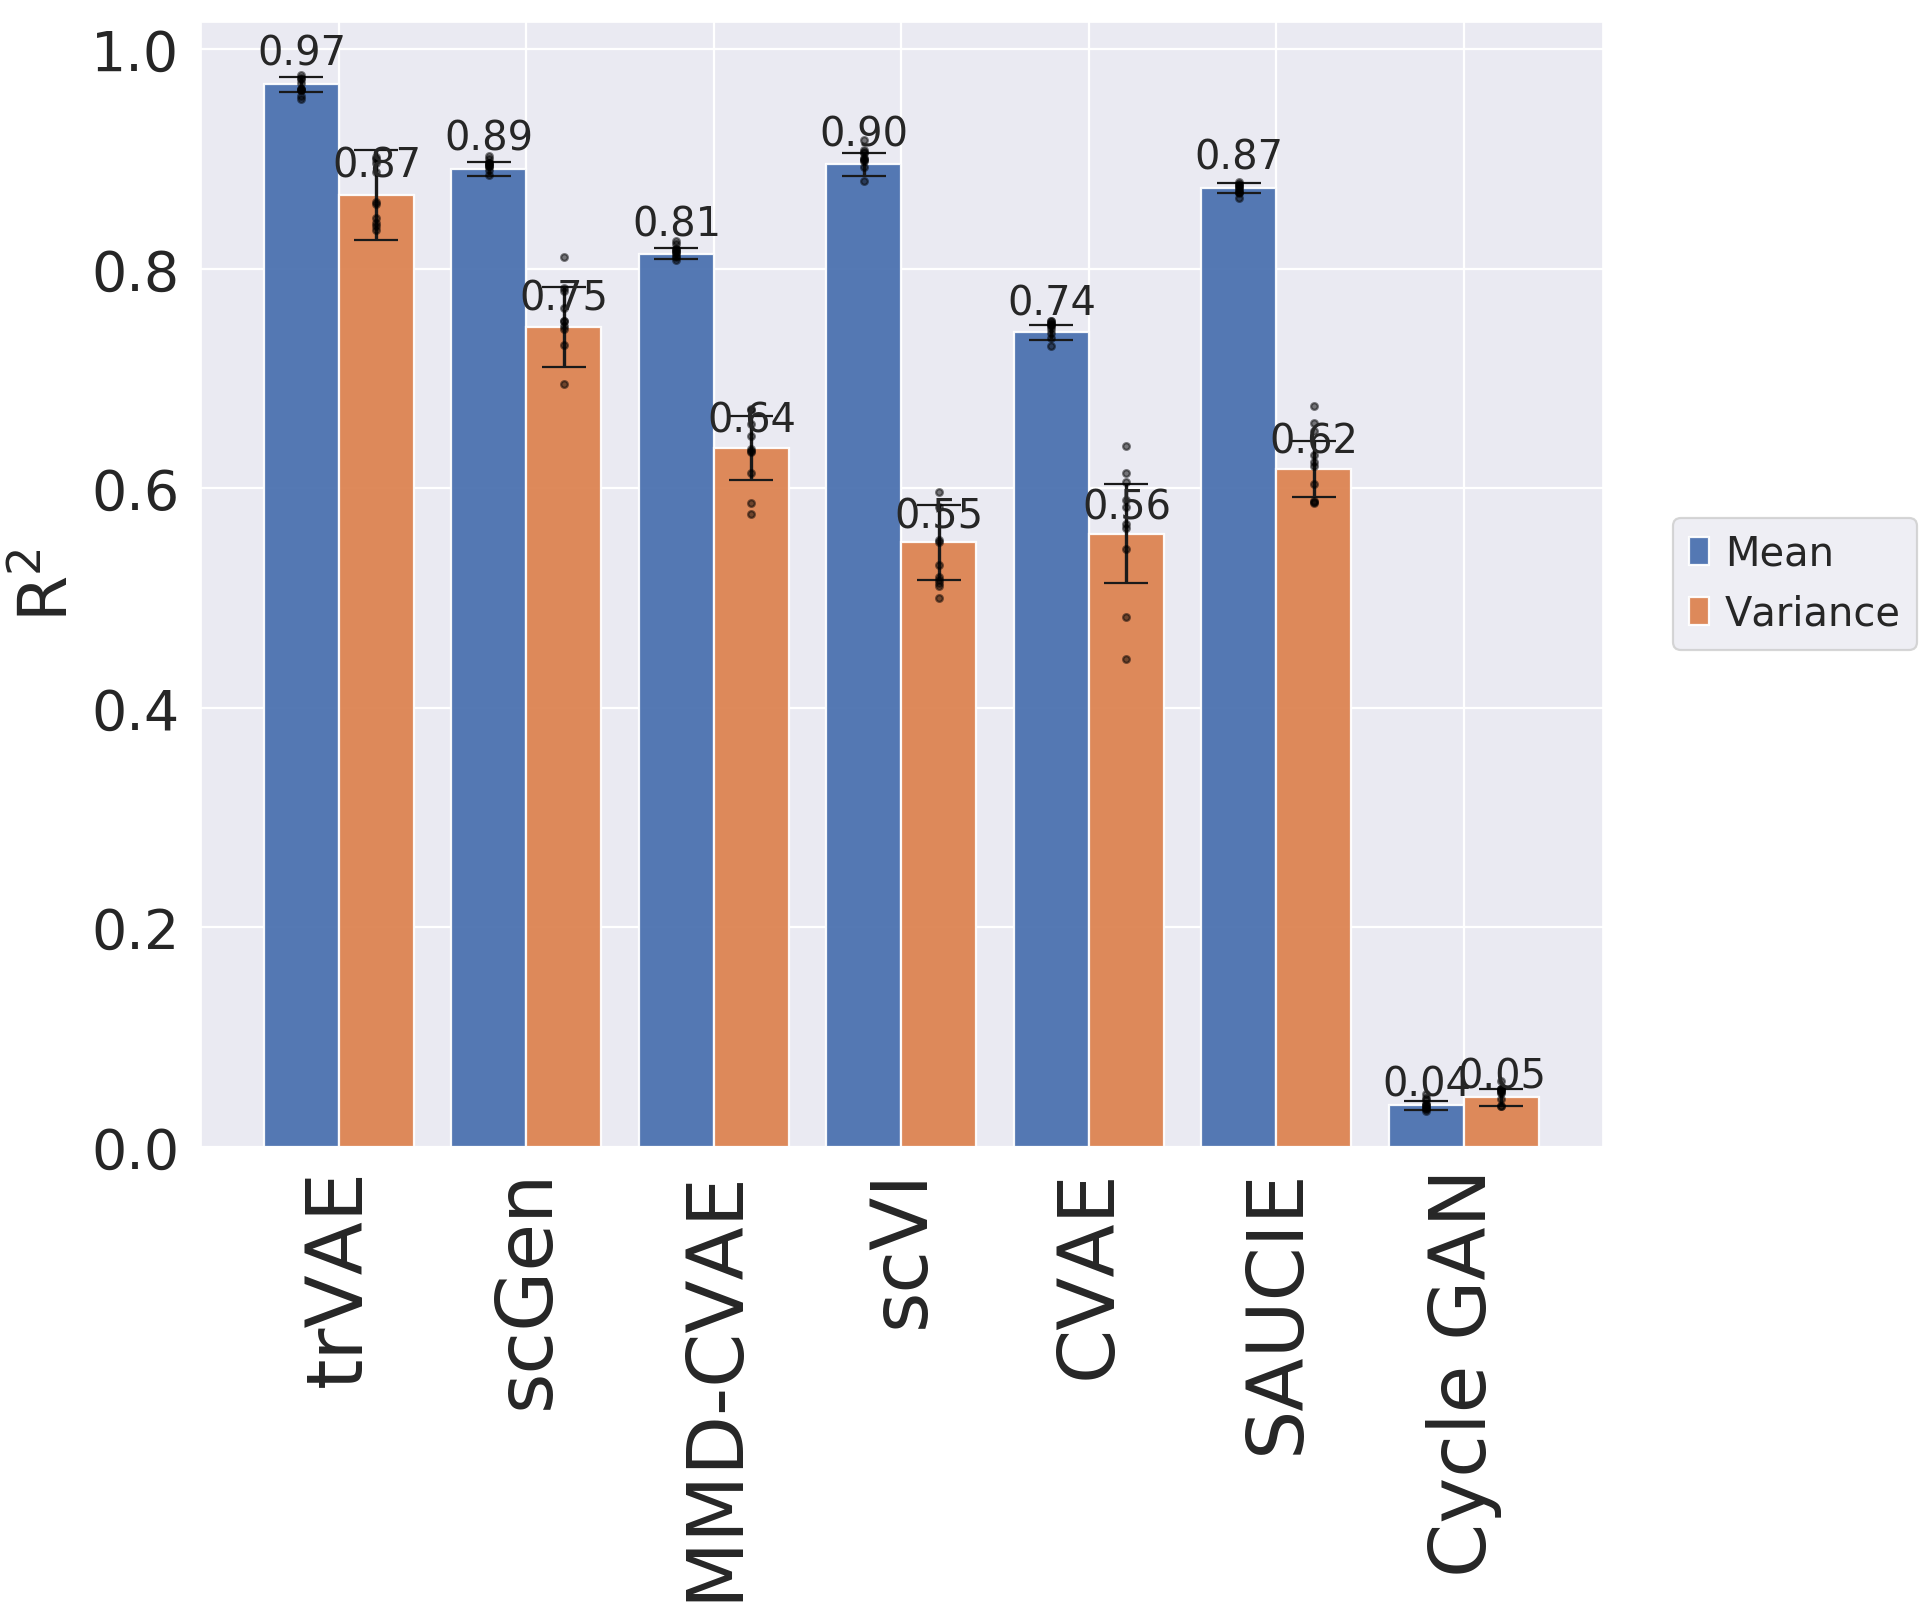

In [31]:
font = {'family' : 'Arial',
        'size'   : 2}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
grouped_barplot(df, 
                "Models", 
                "Type", 
                "R^2", 
                "R^2 Stddevs", 
                put_label=True, 
                legend=True, 
                filename="barplot_model_comparison.pdf", 
                offset=0.4)

# Reg Mean & Reg Var plot for Tuft

In [40]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
adata_pred

AnnData object with n_obs × n_vars = 319 × 1000 
    obs: 'barcode', 'batch', 'cell_label', 'condition', 'method', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [41]:
sc.tl.rank_genes_groups(cell_type_adata, reference='Control', 
                       groupby=condition_key, groups=[target_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition,
                         groupby=condition_key, groups=['Control'],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][target_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names']['Control']

/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [42]:
top_genes = up_genes.tolist() + down_genes.tolist()

reg_mean_top100: 0.9343129979003024
reg_mean_all: 0.9766010063205521


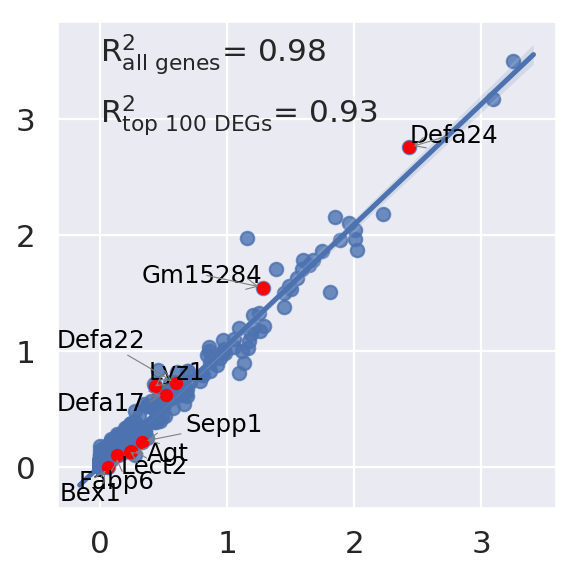

In [43]:
trvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"Control_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, "trVAE_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.8597761289143924
reg_var_all: 0.915105186007987


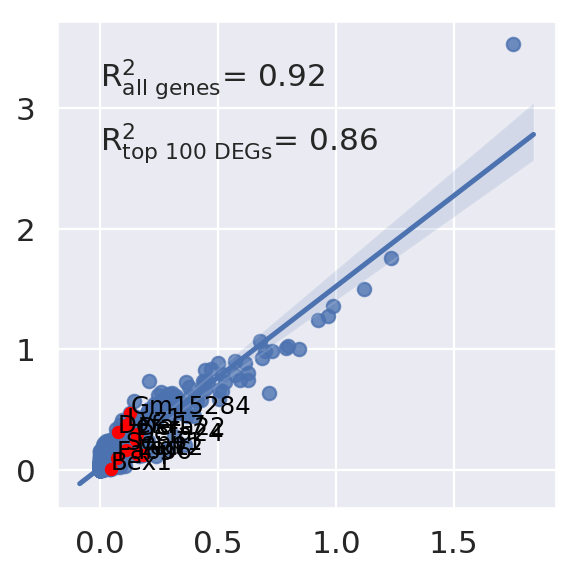

In [44]:
trvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"Control_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, "trVAE_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

# Grouped Barplot 

In [73]:
adata = sc.read("./data/haber/haber.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [74]:
cell_types = adata.obs[cell_type_key].unique().tolist()
cell_types

['Enterocyte.Progenitor',
 'Stem',
 'TA.Early',
 'TA',
 'Tuft',
 'Enterocyte',
 'Goblet',
 'Endocrine']

In [75]:
haber_reconstructed = None
counter = 0
for cell_type in cell_types:
    reconstructed_adata = sc.read(f"../trVAE_reproducibility/data/reconstructed/trVAE_Haber/{cell_type}.h5ad")
    if haber_reconstructed is None:
        haber_reconstructed = reconstructed_adata.copy()
    else:
        haber_reconstructed = haber_reconstructed.concatenate(reconstructed_adata)
haber_reconstructed

AnnData object with n_obs × n_vars = 233912 × 1000 
    obs: 'barcode', 'batch', 'cell_label', 'condition', 'n_counts'

In [76]:
def calc_R2(adata, conditions=None, condition_key="condition", n_trial=100):
    r_values_mean = np.zeros((1, n_trial))
    r_values_var = np.zeros((1, n_trial))
    real_stim = adata[adata.obs[condition_key] == conditions["real_target"]]
    pred_stim = adata[adata.obs[condition_key] == conditions["pred_target"]]
    for i in range(n_trial):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.9 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.9 * real_stim.shape[0]))
                
        if sparse.issparse(pred_stim.X):
            pred_stim.X = pred_stim.X.A
            real_stim.X = real_stim.X.A
            
        x_mean = np.mean(pred_stim.X[pred_stim_idx], axis=0)
        y_mean = np.mean(real_stim.X[real_stim_idx], axis=0)
        
        x_var = np.var(pred_stim.X[pred_stim_idx], axis=0)
        y_var = np.var(real_stim.X[real_stim_idx], axis=0)
        
        m, b, r_value_mean, p_value, std_err = stats.linregress(x_mean, y_mean)
        m, b, r_value_var, p_value, std_err = stats.linregress(x_var, y_var)
        
        r_values_mean[0, i] = r_value_mean ** 2
        r_values_var[0, i] = r_value_var ** 2
    return r_values_mean.mean(), r_values_mean.std(), r_values_var.mean(), r_values_var.std()

In [77]:
def calc_R2_mean_var(reconstructed_adata, cell_types, paths, target_conditions, n_trial=100):
    r2_means, r2_means_std = {key: {} for key in cell_types}, {key: {} for key in cell_types}
    r2_vars, r2_vars_std = {key: {} for key in cell_types}, {key: {} for key in cell_types}
    for cell_type in cell_types:
        cell_type_adata_reconstructed = reconstructed_adata[reconstructed_adata.obs[cell_type_key] == cell_type]
        for path in paths:
            target_condition = path.split("_to_")[-1]
            conditions = {"real_target": target_condition, "pred_target": path}
            r2_mean, r2_mean_std, r2_var, r2_var_std = calc_R2(cell_type_adata_reconstructed, conditions=conditions, n_trial=n_trial)
            print(cell_type, path, r2_mean, r2_mean_std, r2_var, r2_var_std)
            r2_means[cell_type][path] = r2_mean
            r2_means_std[cell_type][path] = r2_mean_std

            r2_vars[cell_type][path] = r2_var
            r2_vars_std[cell_type][path] = r2_var_std
            
    return r2_means, r2_means_std, r2_vars, r2_vars_std

In [78]:
target_conditions = ['Hpoly.Day3', 'Hpoly.Day10', 'Salmonella']
paths = ['Control_to_Hpoly.Day3',
         'Control_to_Hpoly.Day10',
         'Control_to_Salmonella',
        ]
cell_types = haber_reconstructed.obs[cell_type_key].unique().tolist()

In [79]:
r2_all_means, r2_all_means_std, r2_all_vars, r2_all_vars_std = calc_R2_mean_var(haber_reconstructed, cell_types, paths, target_conditions)

Enterocyte.Progenitor Control_to_Hpoly.Day3 0.966661738755599 0.0013419923427517438 0.8804949617942026 0.007957881259702343
Enterocyte.Progenitor Control_to_Hpoly.Day10 0.946612158058906 0.0023406434182569012 0.7150360486195706 0.011016162755661254
Enterocyte.Progenitor Control_to_Salmonella 0.9734926627343254 0.000802574730703783 0.94869526005496 0.0022681353173952573
Stem Control_to_Hpoly.Day3 0.9631620520135017 0.0010611117929290247 0.8933342094029396 0.008858484953335124
Stem Control_to_Hpoly.Day10 0.9618711339341579 0.0006679468091353066 0.8879839041623986 0.0036208149706859864
Stem Control_to_Salmonella 0.9146760734884297 0.002438700189612089 0.8765509219681814 0.004649891187067581
TA.Early Control_to_Hpoly.Day3 0.953654298286915 0.001461708848934913 0.8542341134984167 0.004688624046093842
TA.Early Control_to_Hpoly.Day10 0.9783638996248797 0.0009558121187215611 0.8976228072882877 0.002787378073790442
TA.Early Control_to_Salmonella 0.9540627157565248 0.0010317908741879723 0.849777

In [80]:
df = pd.DataFrame()
df['R^2 Mean'] = None
df['R^2 std'] = None
df['Cell Type'] = None
df['Target'] = None
df

,R^2 Mean,R^2 std,Cell Type,Target


In [82]:
row_idx = 0
for cell_type in r2_all_means.keys():
    for target in r2_all_means[cell_type].keys():
        df.loc[row_idx] = [r2_all_means[cell_type][target], r2_all_means_std[cell_type][target], cell_type, target.split("_to_")[-1]]
        row_idx += 1
df

,R^2 Mean,R^2 std,Cell Type,Target
0,0.966662,0.001342,Enterocyte.Progenitor,Hpoly.Day3
1,0.946612,0.002341,Enterocyte.Progenitor,Hpoly.Day10
2,0.973493,0.000803,Enterocyte.Progenitor,Salmonella
3,0.963162,0.001061,Stem,Hpoly.Day3
4,0.961871,0.000668,Stem,Hpoly.Day10
5,0.914676,0.002439,Stem,Salmonella
6,0.953654,0.001462,TA.Early,Hpoly.Day3
7,0.978364,0.000956,TA.Early,Hpoly.Day10
8,0.954063,0.001032,TA.Early,Salmonella
9,0.940843,0.002158,TA,Hpoly.Day3


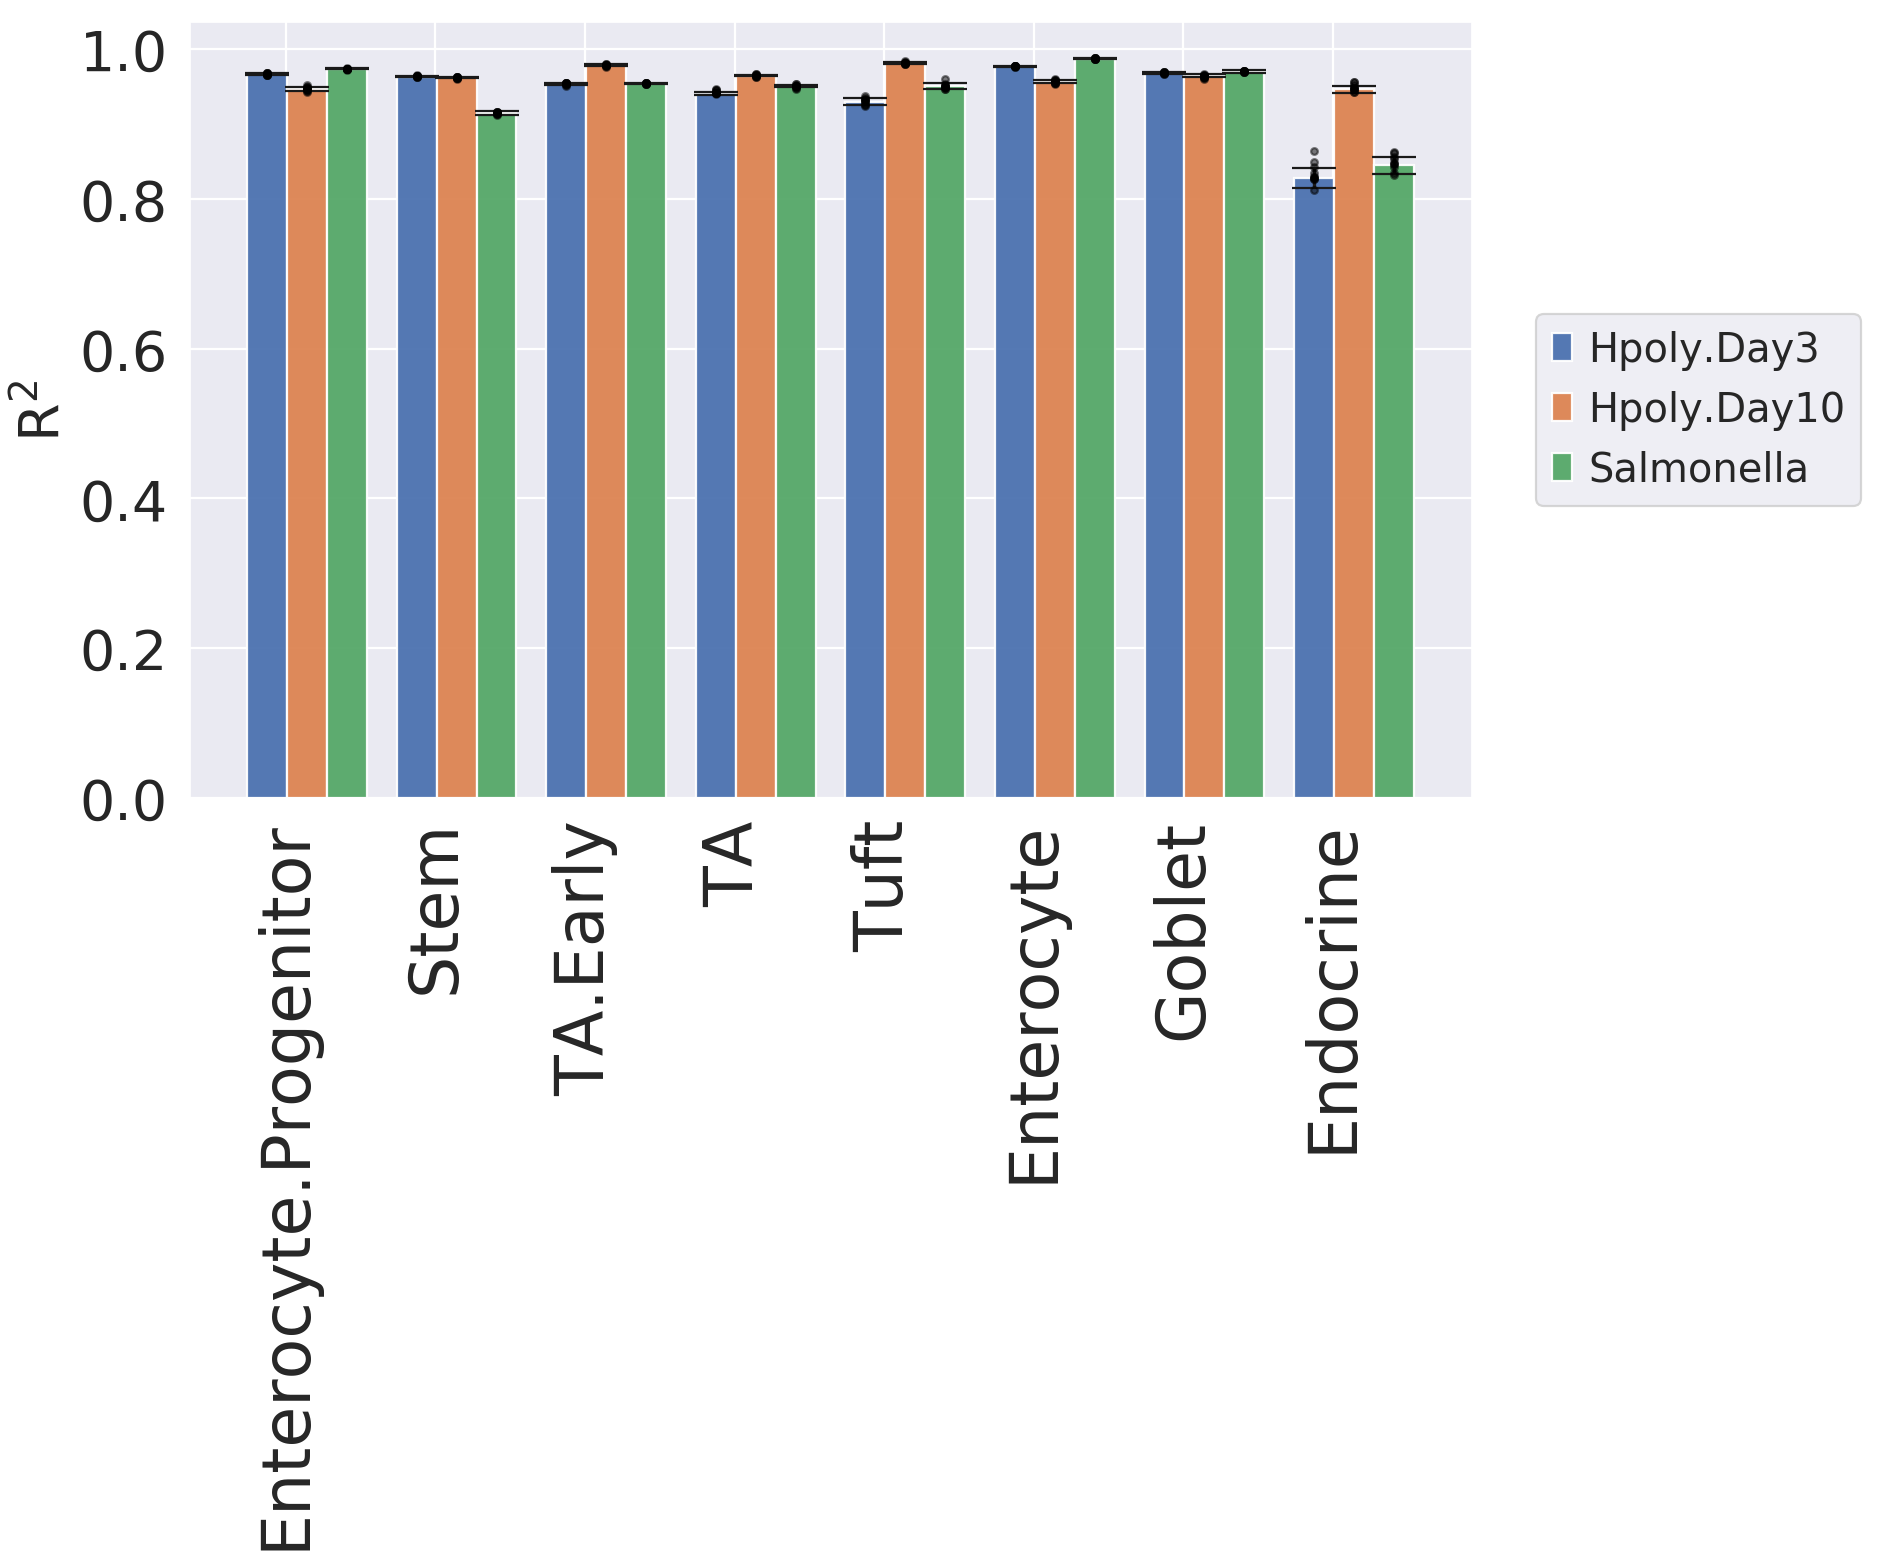

In [83]:
sns.set()
grouped_barplot(df, "Cell Type", "Target", "R^2 Mean", "R^2 std", legend=True, filename="GroupedBarplot_celltypes_mean.pdf", step=3)

In [84]:
df = pd.DataFrame()
df['R^2 Var'] = None
df['R^2 std'] = None
df['Cell Type'] = None
df['Target'] = None
df

,R^2 Var,R^2 std,Cell Type,Target


In [85]:
row_idx = 0
for cell_type in r2_all_means.keys():
    for target in r2_all_means[cell_type].keys():
        df.loc[row_idx] = [r2_all_vars[cell_type][target], r2_all_vars_std[cell_type][target], cell_type, target.split("_to_")[-1]]
        row_idx += 1
df

,R^2 Var,R^2 std,Cell Type,Target
0,0.880495,0.007958,Enterocyte.Progenitor,Hpoly.Day3
1,0.715036,0.011016,Enterocyte.Progenitor,Hpoly.Day10
2,0.948695,0.002268,Enterocyte.Progenitor,Salmonella
3,0.893334,0.008858,Stem,Hpoly.Day3
4,0.887984,0.003621,Stem,Hpoly.Day10
5,0.876551,0.004650,Stem,Salmonella
6,0.854234,0.004689,TA.Early,Hpoly.Day3
7,0.897623,0.002787,TA.Early,Hpoly.Day10
8,0.849778,0.005286,TA.Early,Salmonella
9,0.854911,0.004382,TA,Hpoly.Day3


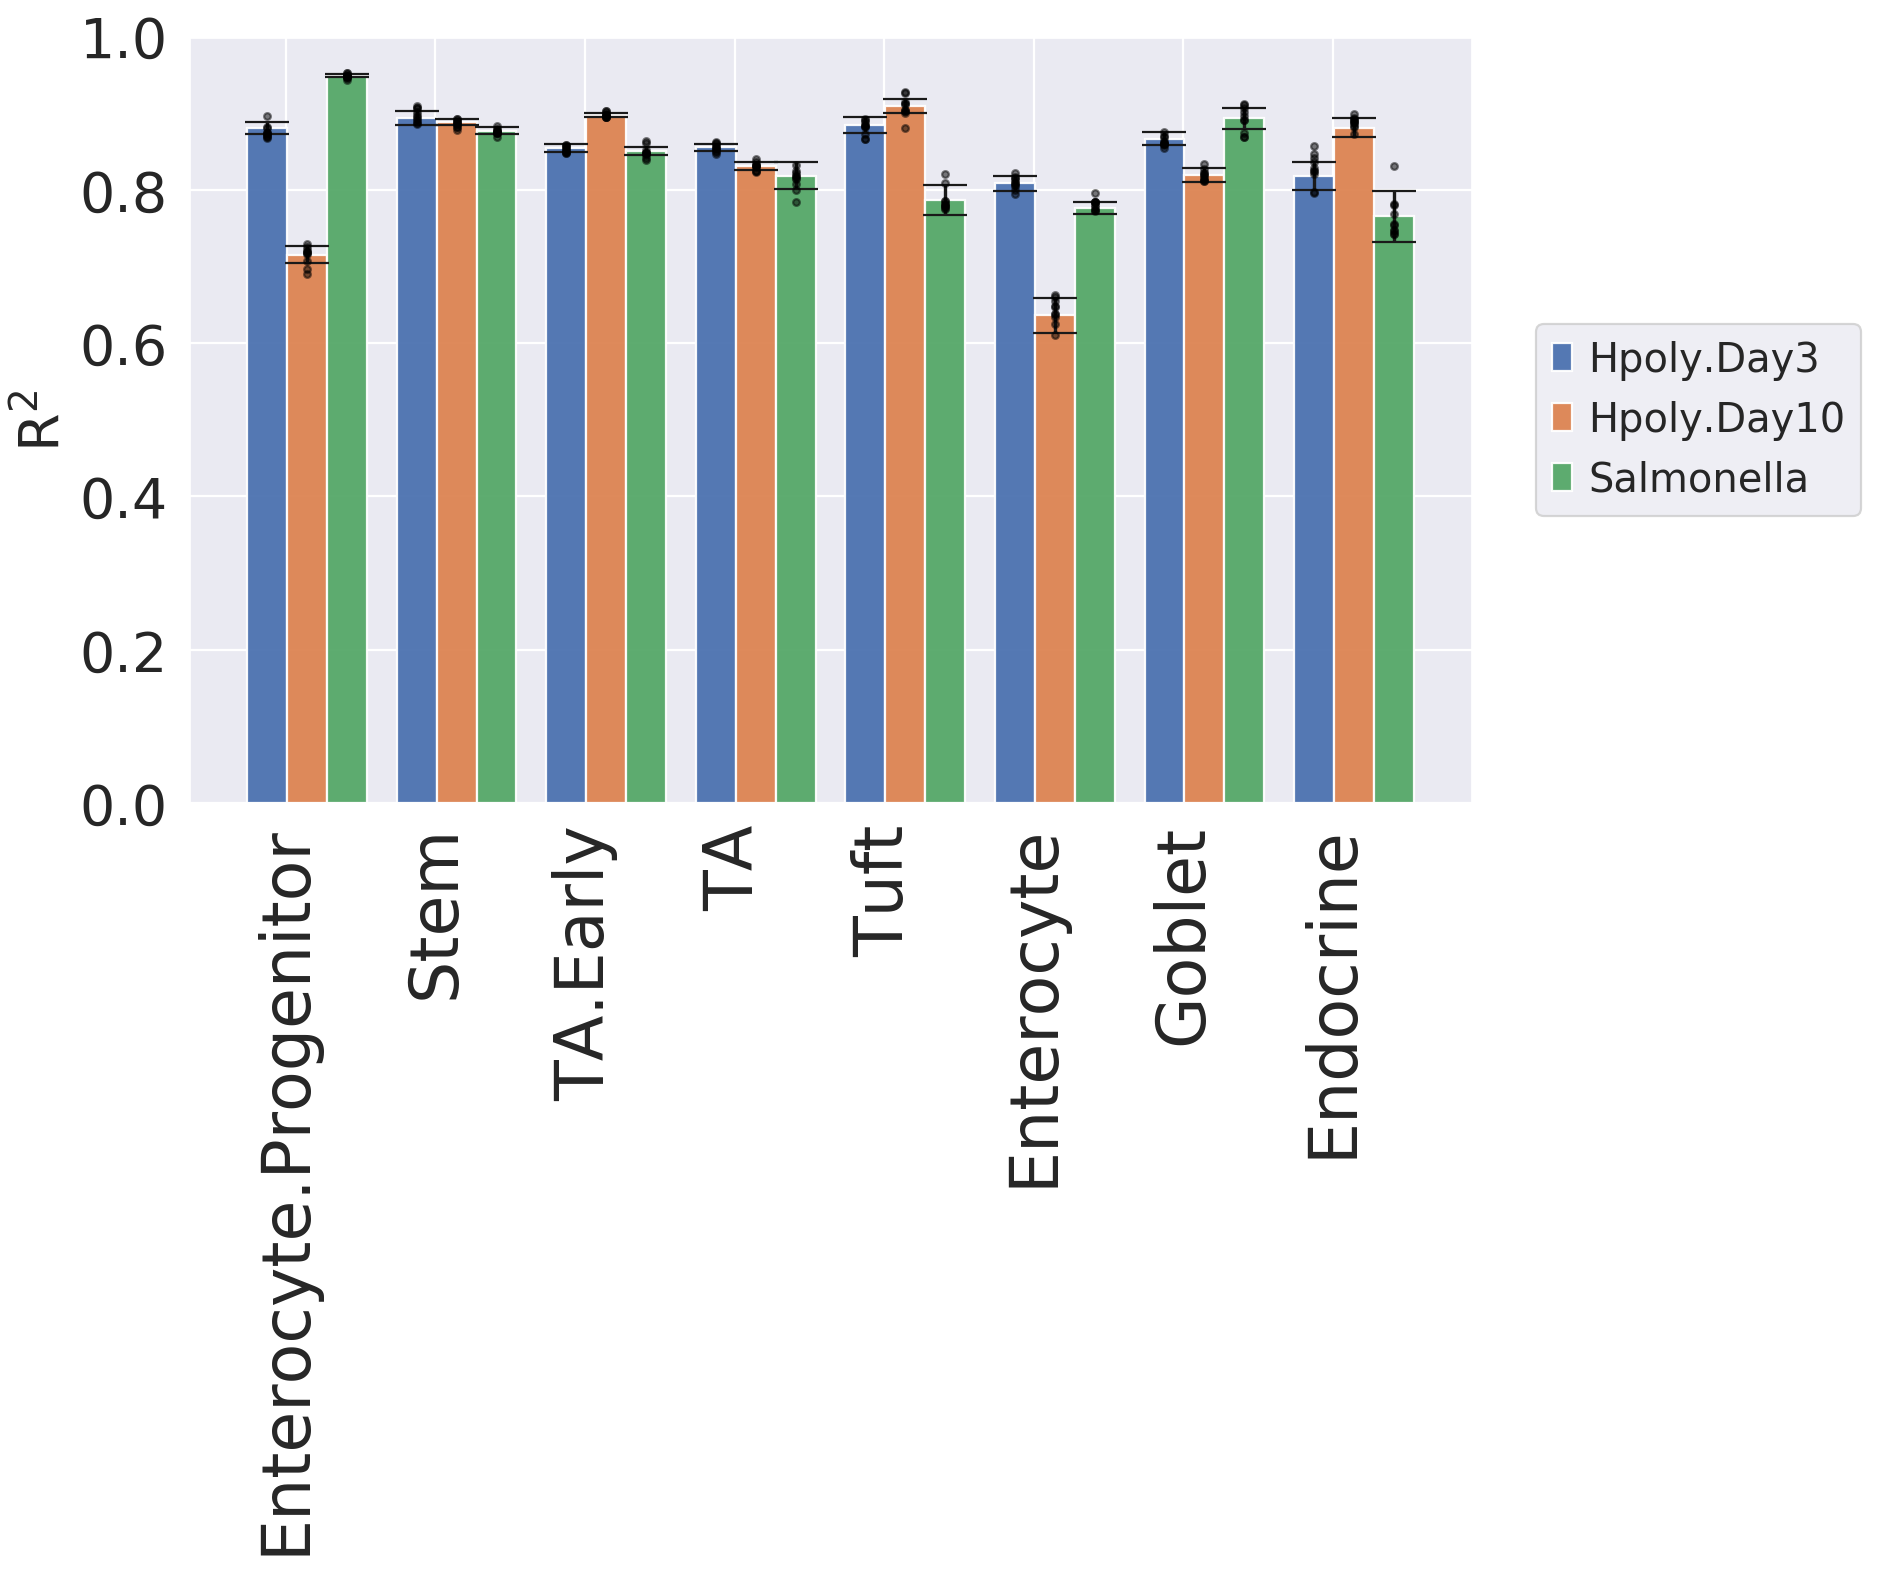

In [86]:
sns.set()
grouped_barplot(df, "Cell Type", "Target", "R^2 Var", "R^2 std", legend=True, filename="GroupedBarplot_celltypes_var.pdf", step=3)